In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
## load tokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen1.5-0.5B", trust_remote_code=True)

## load base model
base_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen1.5-0.5B",
    trust_remote_code=True,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    device_map="auto",
)

#LORA_PATH = "../models/gwen-lora-goemotions"
## load peft model
model = PeftModel.from_pretrained(
    base_model,
    '/content/drive/MyDrive/moodmate/models/qwen-lora-goemotions/',
)

model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 1024)
        (layers): ModuleList(
          (0-23): 24 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=1024, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in_featu

In [13]:
DATA_PATH = "/content/drive/MyDrive/moodmate/data/goemotions_final.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,text,final_emotion
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",anger
1,"""What do Scottish people look like?"" How I wo...",neutral
2,"### A surprise, to be sure, but a welcome one",surprise
3,"'*Pray*, v. To ask that the laws of the unive...",neutral
4,">it'll get invaded by tankie, unfortunately. ...",neutral


In [14]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df["final_emotion"]
)

print("Train size:", len(train_df))
print("Test size:", len(test_df))

Train size: 49529
Test size: 5504


In [15]:
## prediction function

def predict_emotion(text: str) -> str:
    prompt = (
        "Instruction: Identify the emotion of the following text.\n"
        f"Text: {text}\n"
        "Emotion:"
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=5,
            do_sample=False
        )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the emotion after "Emotion:"
    emotion = decoded.split("Emotion:")[-1].strip().split()[0]
    return emotion

In [16]:
## sampling 500
test_subset = test_df.sample(n=500, random_state=42)

y_true = []
y_pred = []

for _, row in test_subset.iterrows():
    y_true.append(row["final_emotion"])
    y_pred.append(predict_emotion(row["text"]))

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for

In [17]:
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

Accuracy: 0.68

Classification Report:

              precision    recall  f1-score   support

       anger       0.47      0.57      0.52        60
     anxiety       0.33      0.17      0.22         6
         joy       0.60      0.66      0.63        74
        love       0.78      0.66      0.71        68
     neutral       0.75      0.82      0.78       241
     sadness       0.79      0.27      0.40        41
    surprise       0.33      0.30      0.32        10

    accuracy                           0.68       500
   macro avg       0.58      0.49      0.51       500
weighted avg       0.69      0.68      0.67       500



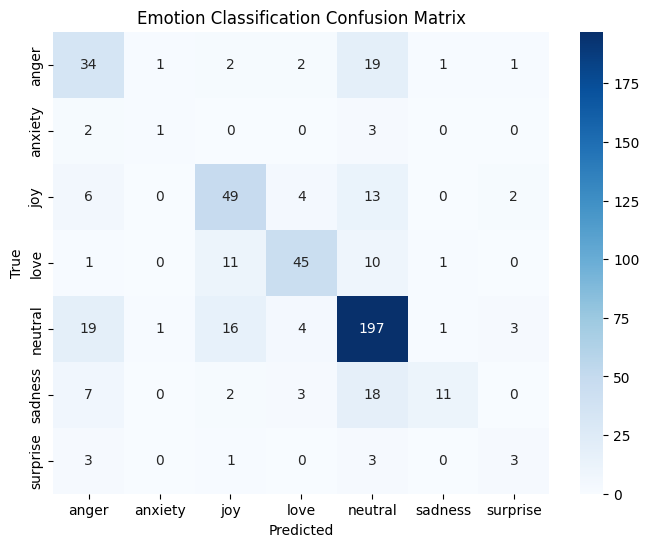

In [18]:
## confusion matrix

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=sorted(df["final_emotion"].unique()))

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=sorted(df["final_emotion"].unique()),
    yticklabels=sorted(df["final_emotion"].unique()),
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Emotion Classification Confusion Matrix")
plt.show()

In [20]:
results_df = test_subset.copy()
results_df["predicted_emotion"] = y_pred

# Correct predictions
results_df[results_df["final_emotion"] == results_df["predicted_emotion"]].head(10)

,text,final_emotion,predicted_emotion
22128,Is there a university in China? Are we in 5019?,neutral,neutral
25070,LOL to your family,joy,joy
30733,"Ok, will do man! Thanks. Edit: I forgot to men...",love,love
19109,I will still shag her u fooking poof. gave im ...,neutral,neutral
9326,"Funny enough, there is a five guys. I don't th...",joy,joy
16113,I left the profession for exactly that reason....,neutral,neutral
27940,Nahhh just as they came to me,neutral,neutral
16990,I mean I guess your prostate is healthy right?,neutral,neutral
44668,What did it say? The mods on /r/rant deleted it.,neutral,neutral
26464,Man i wish [NAME] expelled you for forgetting ...,neutral,neutral


In [21]:
# InCorrect predictions
results_df[results_df["final_emotion"] != results_df["predicted_emotion"]].head(5)

,text,final_emotion,predicted_emotion
1389,> it will not make her look like an idiot It w...,anger,neutral
49099,You smile warmly at people.,love,joy
9132,Friend got me into football by watching Detroi...,neutral,joy
39786,There are other petty crimes that can be more ...,anger,neutral
24262,I’m so jealous,anger,joy
